In [1]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.stats as stats

In [2]:
ctc = sc.read_h5ad('/mnt/c/Users/ouyangkang/Desktop/ctc_with_anno.h5ad')

In [3]:
ctc

AnnData object with n_obs × n_vars = 21408 × 36472
    obs: 'total_counts', 'pct_counts_mt', 'pct_counts_rb', 'pct_counts_hb', 'n_genes', 'doublet_score', 'chip_id', 'patient_info', 'phage_info', '_scvi_batch', '_scvi_labels', 'leiden', 'anno', 'chip_color', 'anno_ctc'
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'anno_colors', 'anno_ctc_colors', 'chip_id_colors', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'umap'
    obsm: 'X_scVI', 'X_umap', '_scvi_extra_categorical_covs', '_scvi_extra_continuous_covs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [4]:
ctc_index = ctc.obs[ctc.obs['anno_ctc'] == 'True CTC'].index
ctc = ctc[ctc_index, :]

In [5]:
# exclude negative sample
negative_sample = ['A04086G3', 'C03427D3', 'A04230E2', 'A04230E4_16', 'A04224E3']
positive_index = ctc.obs[~ctc.obs['chip_id'].isin(negative_sample)].index
ctc = ctc[positive_index, :]

In [6]:
sc.pp.filter_genes(ctc, min_cells=1)

/home/ouyangkang/software/miniconda3/envs/sc/lib/python3.11/site-packages/scanpy/preprocessing/_simple.py:275: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number


In [7]:
ctc

AnnData object with n_obs × n_vars = 261 × 21692
    obs: 'total_counts', 'pct_counts_mt', 'pct_counts_rb', 'pct_counts_hb', 'n_genes', 'doublet_score', 'chip_id', 'patient_info', 'phage_info', '_scvi_batch', '_scvi_labels', 'leiden', 'anno', 'chip_color', 'anno_ctc'
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'anno_colors', 'anno_ctc_colors', 'chip_id_colors', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'umap'
    obsm: 'X_scVI', 'X_umap', '_scvi_extra_categorical_covs', '_scvi_extra_continuous_covs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [8]:
sc.pp.highly_variable_genes(
    ctc,
    flavor="seurat_v3",
    n_top_genes=1500,
    layer="counts",
    batch_key="chip_id",
    span=1
)

In [9]:
ctc.X = ctc.layers['counts'].copy()

In [11]:
sc.pp.normalize_total(ctc, target_sum=1e4)
sc.pp.log1p(ctc)

In [12]:
sc.tl.pca(ctc, svd_solver='arpack')

In [13]:
sc.external.pp.harmony_integrate(ctc, 'chip_id')

2025-05-12 17:35:08,267 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-05-12 17:35:08,310 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-05-12 17:35:08,312 - harmonypy - INFO - Iteration 1 of 10
2025-05-12 17:35:08,348 - harmonypy - INFO - Iteration 2 of 10
2025-05-12 17:35:08,389 - harmonypy - INFO - Iteration 3 of 10
2025-05-12 17:35:08,421 - harmonypy - INFO - Iteration 4 of 10
2025-05-12 17:35:08,443 - harmonypy - INFO - Iteration 5 of 10
2025-05-12 17:35:08,460 - harmonypy - INFO - Iteration 6 of 10
2025-05-12 17:35:08,478 - harmonypy - INFO - Iteration 7 of 10
2025-05-12 17:35:08,507 - harmonypy - INFO - Iteration 8 of 10
2025-05-12 17:35:08,531 - harmonypy - INFO - Iteration 9 of 10
2025-05-12 17:35:08,551 - harmonypy - INFO - Iteration 10 of 10
2025-05-12 17:35:08,600 - harmonypy - INFO - Stopped before convergence


In [14]:
sc.pp.neighbors(ctc, use_rep='X_pca_harmony')

/home/ouyangkang/software/miniconda3/envs/sc/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
sc.tl.leiden(ctc, n_iterations=-1, flavor='igraph')

In [20]:
sc.tl.umap(ctc, spread=2)

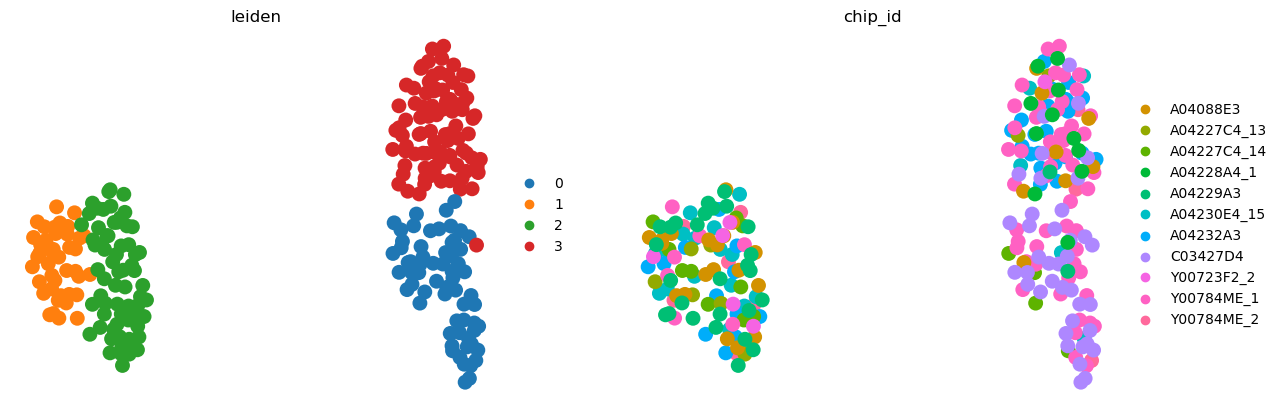

In [21]:
sc.pl.umap(ctc, color=["leiden", 'chip_id'], frameon=False)

In [25]:
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, cophenet
from sklearn.decomposition import NMF
import matplotlib.pyplot as plt


def compute_cophenetic(W_matrix):
    """
    给定 W 矩阵，计算共识矩阵和 CCC
    """
    consensus_matrix = np.zeros((W_matrix.shape[0], W_matrix.shape[0]))

    for i in range(W_matrix.shape[0]):
        for j in range(W_matrix.shape[0]):
            consensus_matrix[i, j] = np.dot(W_matrix[i], W_matrix[j]) / (
                np.linalg.norm(W_matrix[i]) * np.linalg.norm(W_matrix[j])
            )

    # 构建距离矩阵和树状聚类
    dist = 1 - consensus_matrix
    np.fill_diagonal(dist, 0)
    linkage_matrix = linkage(squareform(dist), method='average')
    ccc, _ = cophenet(linkage_matrix, squareform(dist))
    return ccc

def sparsity(x):
    """Hoyer's sparsity measure (0: dense, 1: sparse)"""
    if np.linalg.norm(x, 1) == 0:
        return 0
    n = len(x)
    return (np.sqrt(n) - np.linalg.norm(x, 1)/np.linalg.norm(x, 2)) / (np.sqrt(n) - 1)

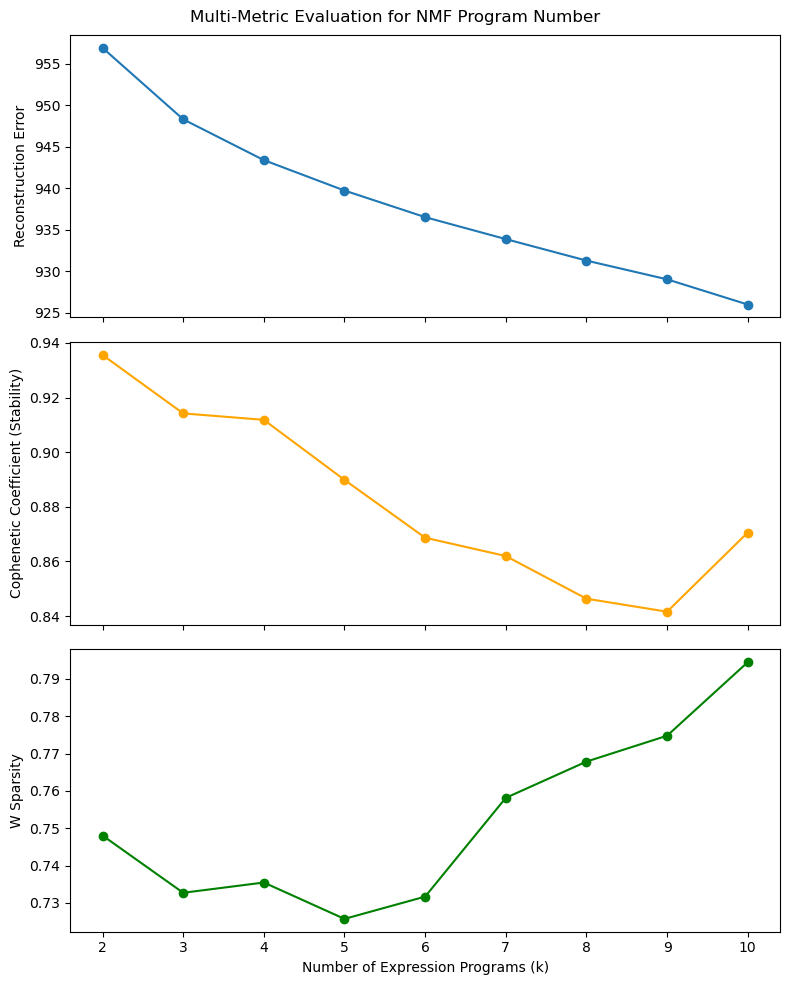

In [26]:
X = ctc.X

components_range = range(2, 11)
recons_err, cophen_scores, sparsities = [], [], []

for n in components_range:
    nmf_model = NMF(n_components=n, init="nndsvd", random_state=0, max_iter=2000)
    W = nmf_model.fit_transform(X)
    H = nmf_model.components_

    # error
    recons_err.append(nmf_model.reconstruction_err_)
    # coefficient
    ccc = compute_cophenetic(W)
    cophen_scores.append(ccc)
    # sparsity
    sparsities.append(np.mean([sparsity(row) for row in W]))


# plot
fig, ax = plt.subplots(3, 1, figsize=(8, 10), sharex=True)

ax[0].plot(components_range, recons_err, marker='o')
ax[0].set_ylabel("Reconstruction Error")

ax[1].plot(components_range, cophen_scores, marker='o', color='orange')
ax[1].set_ylabel("Cophenetic Coefficient (Stability)")

ax[2].plot(components_range, sparsities, marker='o', color='green')
ax[2].set_ylabel("W Sparsity")

plt.xlabel("Number of Expression Programs (k)")
plt.suptitle("Multi-Metric Evaluation for NMF Program Number")
plt.tight_layout()
plt.show()

In [27]:
# the besk number of programs is 5
nmf_model = NMF(n_components=5, init='nndsvda', random_state=0, max_iter=2000)
W = nmf_model.fit_transform(X)
H = nmf_model.components_

ctc.obsm["X_nmf"] = W
ctc.uns["nmf_H"] = H

genes = ctc.var_names
H_df = pd.DataFrame(H, columns=genes)
top_genes_dict = {
    f"Program_{i+1}": H_df.iloc[i].sort_values(ascending=False).head(50).index.tolist()
    for i in range(H.shape[0])
}

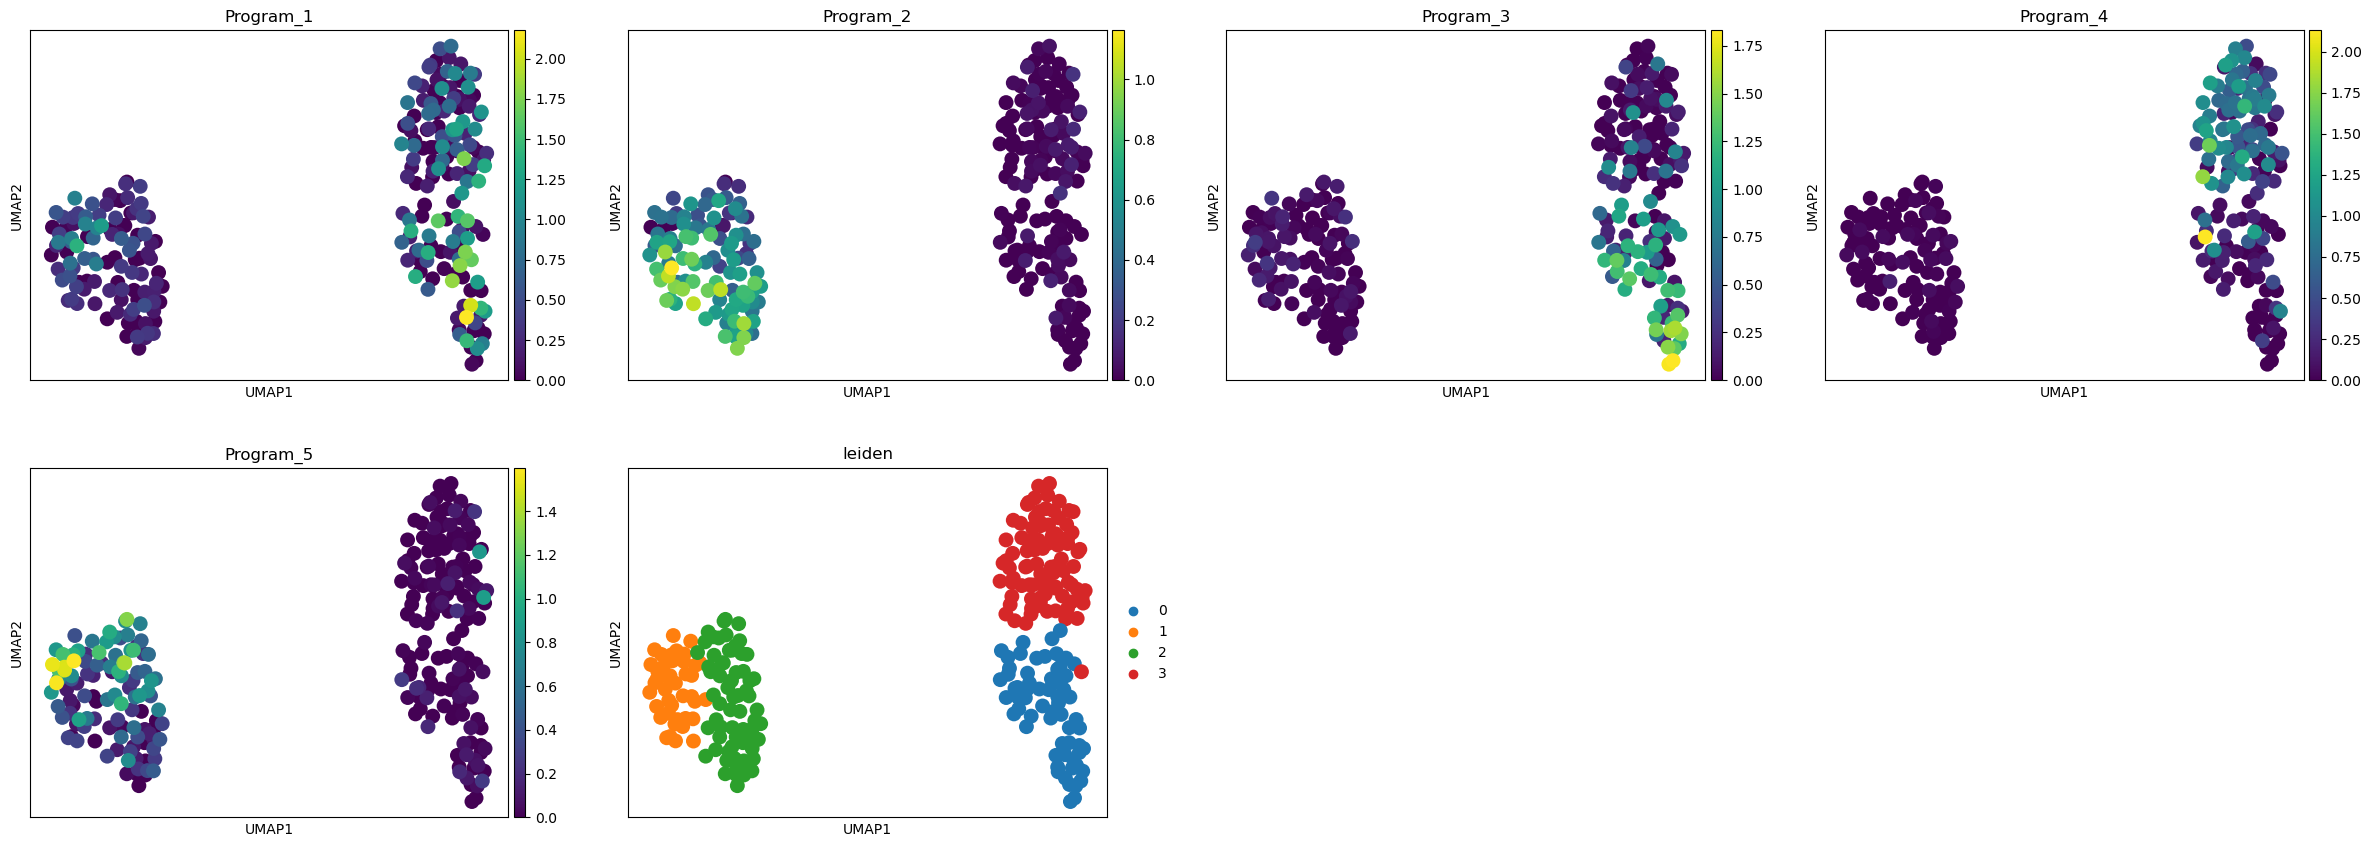

In [28]:
for i in range(W.shape[1]):
    ctc.obs[f"Program_{i+1}"] = W[:, i]

sc.pl.umap(ctc, color=['Program_1', 'Program_2', 'Program_3', 'Program_4', 'Program_5', 'leiden'])

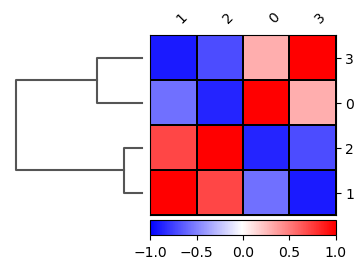

In [29]:
sc.tl.dendrogram(ctc, groupby='leiden')
sc.pl.correlation_matrix(ctc, 'leiden', )

In [30]:
import gseapy as gp

results = {}
for name, genes in top_genes_dict.items():
    enr = gp.enrichr(gene_list=genes,
                     gene_sets=['GO_Biological_Process_2025', 'GO_Molecular_Function_2025', 'GO_Cellular_Component_2025'],
                     organism='Human',
                     outdir=None)
    results[name] = enr.results[['Term', 'Adjusted P-value', 'Adjusted P-value', 'Genes']]
    enr.results.to_csv(f'/mnt/c/Users/ouyangkang/Desktop/enrichment_{name}.csv')

In [12]:
sc.tl.rank_genes_groups(ctc, groupby='leiden', method='wilcoxon')

In [9]:
result = ctc.uns['rank_genes_groups']

# get cluster names
groups = result['names'].dtype.names

df = pd.DataFrame()

# extract top 200 genes for each group
for group in groups:
    genes = result['names'][group][:200]
    df[group] = genes


# save HVG to csv
df.to_csv('/mnt/c/Users/ouyangkang/Desktop/hvg_ctc.csv')

# CTC Heterogeneity

## EMT ctcs

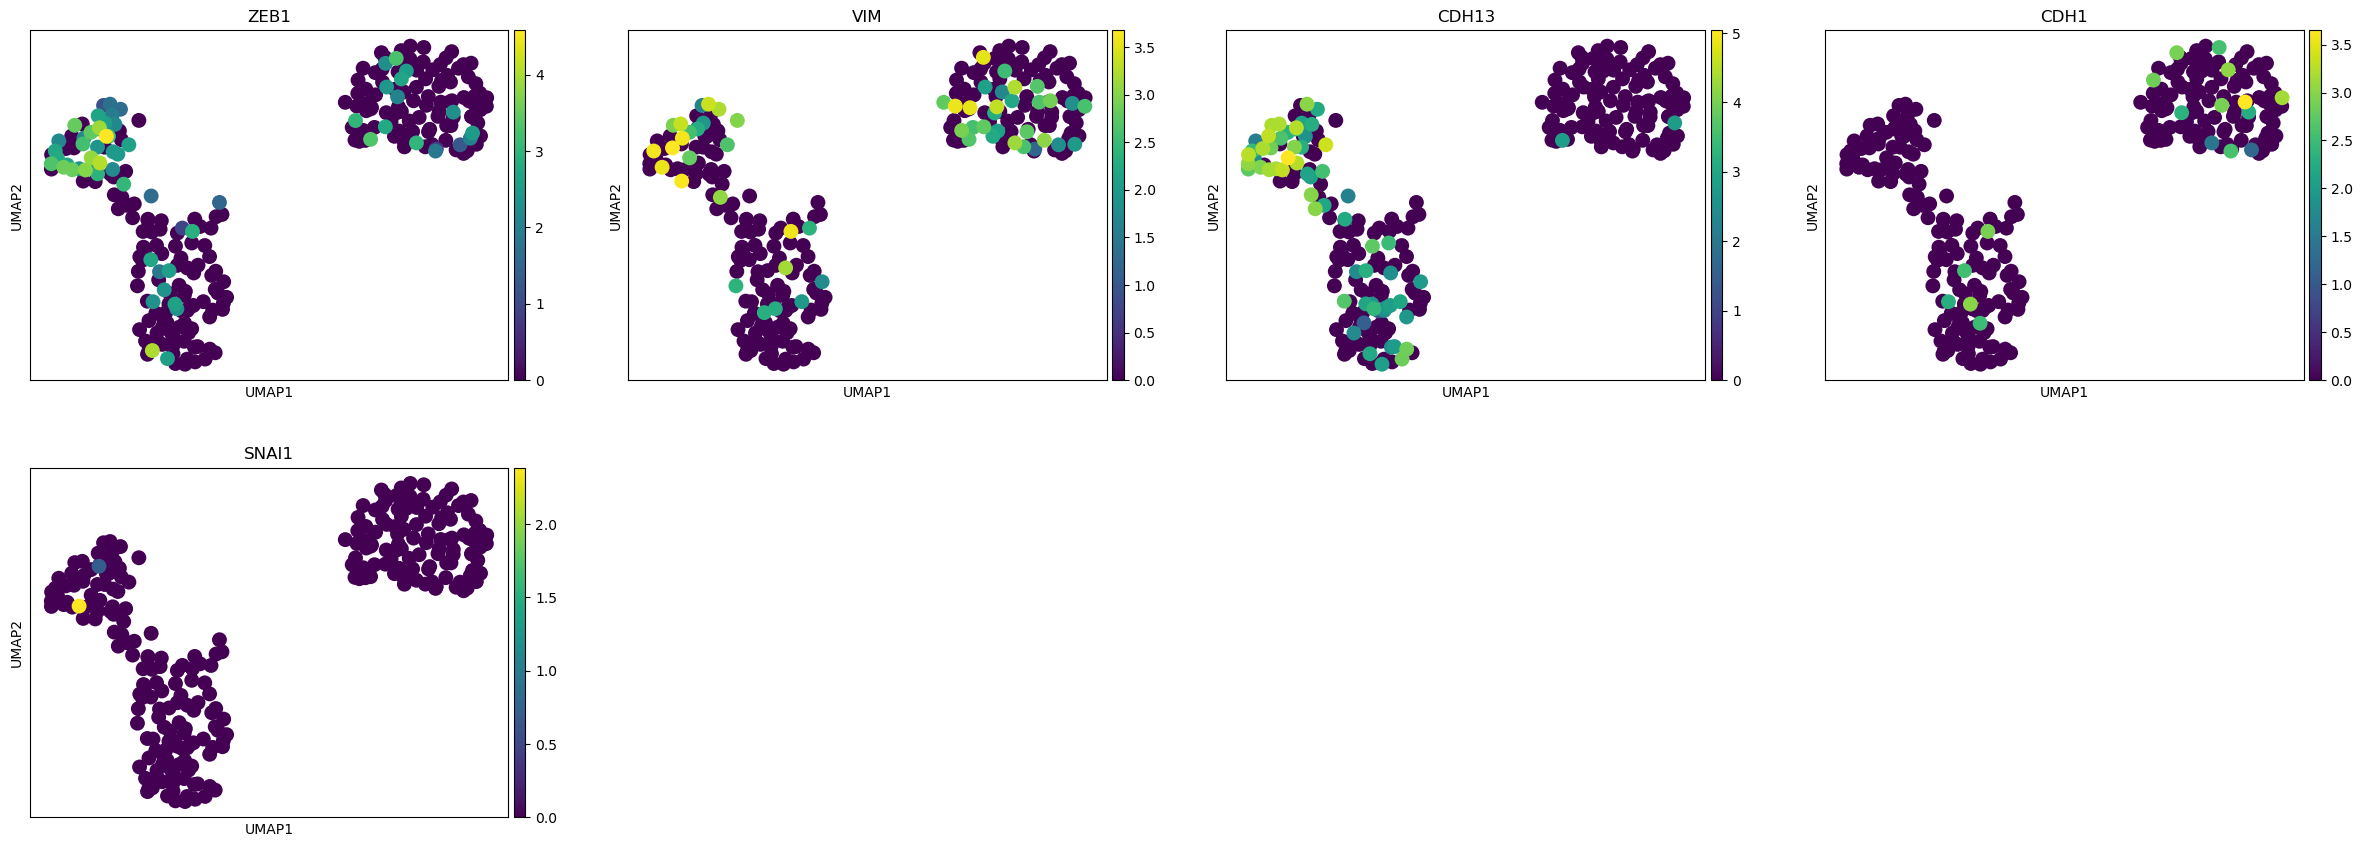

In [15]:
# CDH1: the epithelial cell marker, which expression level decrease in the process of EMT
# CDH13, VIM: Mesenchymal cell markers, which expression level increase in the process of EMT
# ZEB1, : the epithelial cell marker, which expression level decrease in the process of EMT
sc.pl.umap(ctc, color=['ZEB1', 'VIM', 'CDH13', 'CDH1', 'SNAI1'], vmin=0)

In [22]:
pd.DataFrame(ctc.X.todense(), columns=ctc.var_names, index=ctc.obs_names).to_csv('/mnt/c/Users/ouyangkang/Desktop/ctc_exp_mtx.csv')

In [29]:
import scipy.sparse as sparse
import scipy.io as sio
import scipy.stats as stats

cell_info = ctc.obs
gene_info = ctc.var
mtx = ctc.X.T

cell_info.to_csv('/mnt/c/Users/ouyangkang/Desktop/ctc_cell_info.csv')
gene_info.to_csv('/mnt/c/Users/ouyangkang/Desktop/ctc_gene_info.csv')
sio.mmwrite('/mnt/c/Users/ouyangkang/Desktop/ctc.mtx', mtx)

In [28]:
gene_info

,n_cells,highly_variable,highly_variable_rank,means,variances,variances_norm,highly_variable_nbatches
A2M,9,False,1455.5,0.036481,0.082714,0.793055,2
A2ML1,3,False,NaN,0.004292,0.006726,0.470115,0
A2MP1,6,False,NaN,0.013883,0.023589,0.829817,0
A4GALT,4,False,NaN,0.002540,0.004461,0.740487,0
AACSP1,3,False,NaN,0.001796,0.002756,0.383209,0
...,...,...,...,...,...,...,...
ZWILCH,5,False,1246.5,0.053867,0.127436,0.884688,2
ZXDC,8,False,NaN,0.332224,0.856556,0.816089,0
ZYG11A,3,False,NaN,0.016073,0.033771,0.773831,0
ZYG11B,12,False,NaN,0.173250,0.423975,0.936111,0


In [16]:
heteogeneity_mapping = {
    "0" : "EMT",
    "1":  "stem",
    "2":  "stem",
    "3":  "tmp_unknown",
    "4":  "tmp_unknown"
}
ctc.obs['ctc_heteogeneity'] = ctc.obs['leiden'].replace(heteogeneity_mapping)

/tmp/ipykernel_25070/3359396763.py:8: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  ctc.obs['ctc_heteogeneity'] = ctc.obs['leiden'].replace(heteogeneity_mapping)


In [ ]:
# csc
sc.pl.umap(ctc, color=['SOX2', 'NR2F1', 'ICAM1'], vmin=0)

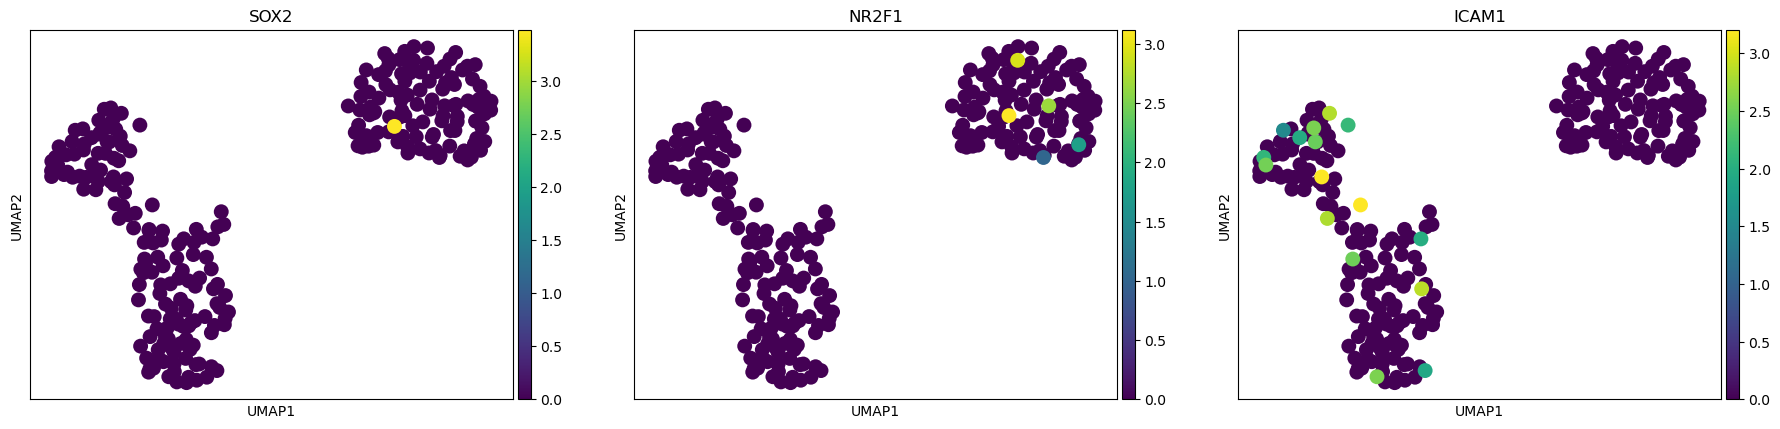

In [20]:
# csc
sc.pl.umap(ctc, color=['SOX2', 'NR2F1', 'ICAM1'], vmin=0)

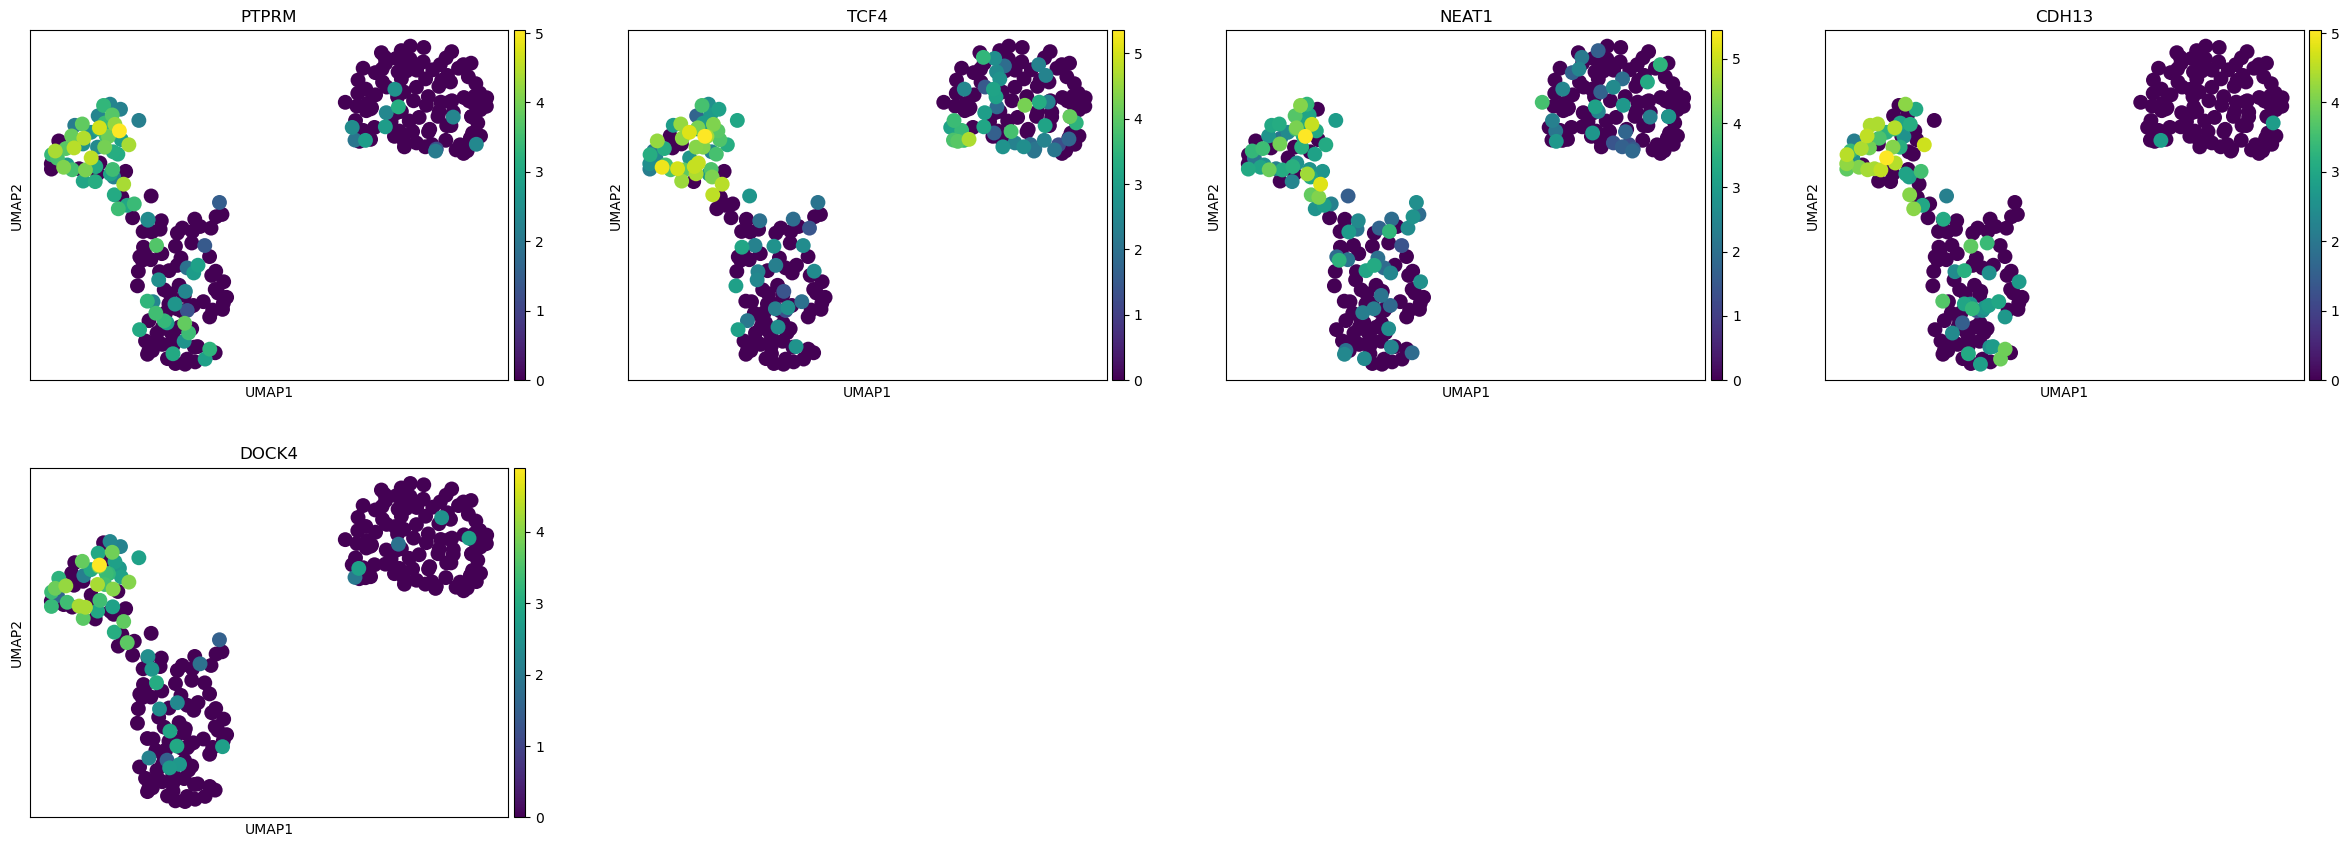

In [28]:
sc.pl.umap(ctc, color=['PTPRM', 'TCF4', 'NEAT1', 'CDH13', 'DOCK4'], vmin='0')

In [59]:
cell_cycle_genes = pd.read_csv('/mnt/c/Users/ouyangkang/Desktop/cell_cycle.csv')
# cell_cycle_genes.head()
s_gene = cell_cycle_genes[cell_cycle_genes.columns[0]][:43] 
g2m_gene = cell_cycle_genes[cell_cycle_genes.columns[0]][43:]

s_gene = [i for i in s_gene if i in ctc.var_names]
g2m_gene = [i for i in g2m_gene if i in ctc.var_names]

sc.tl.score_genes_cell_cycle(ctc, s_genes=s_gene, g2m_genes=g2m_gene)

In [60]:
ctc.obs.head()

,total_counts,pct_counts_mt,pct_counts_rb,pct_counts_hb,n_genes,doublet_score,chip_id,patient_info,phage_info,_scvi_batch,_scvi_labels,leiden,anno,chip_color,anno_ctc,S_score,G2M_score,phase
404.0-Y00784ME_2,9445.0,2.932769,0.688195,0.0,2322,0.055901,Y00784ME_2,Patient_13,S2,0,0,0,CTC,#FF699C,True CTC,-0.069064,-0.028930,G1
516.0-Y00784ME_2,1908.0,12.631027,2.987421,0.0,828,0.055901,Y00784ME_2,Patient_13,S2,0,0,1,CTC,#FF699C,True CTC,0.064151,-0.001314,S
511.0-Y00784ME_2,862.0,15.429234,1.160093,0.0,394,0.040404,Y00784ME_2,Patient_13,S2,0,0,2,CTC,#FF699C,True CTC,0.001060,-0.050913,S
547.0-Y00784ME_2,1327.0,15.523738,0.828937,0.0,647,0.080645,Y00784ME_2,Patient_13,S2,0,0,2,CTC,#FF699C,True CTC,-0.004636,-0.074726,G1
727.0-Y00784ME_2,1132.0,11.042403,2.915194,0.0,584,0.022059,Y00784ME_2,Patient_13,S2,0,0,2,CTC,#FF699C,True CTC,0.002970,0.020995,G2M


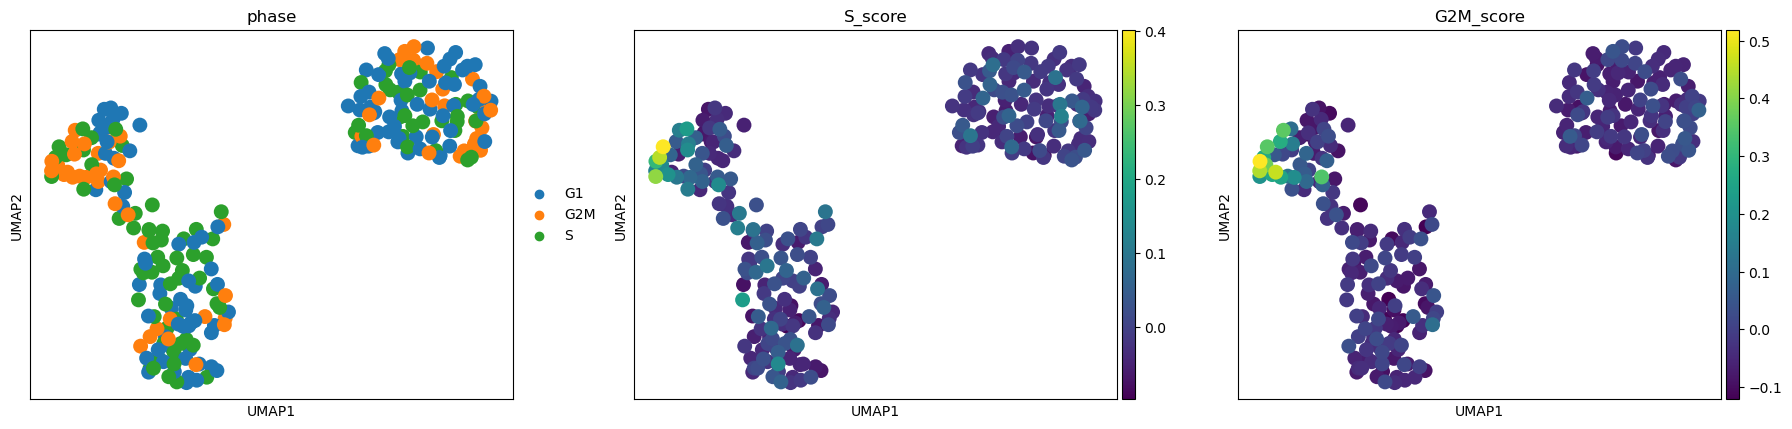

In [61]:
sc.pl.umap(ctc, color=['phase', 'S_score', 'G2M_score'])

In [66]:
dormancy_markers = ['CDKN1B', 'NR2F1', 'SOX9', 'TGFBI', 'G0S2']
sc.tl.score_genes(ctc, dormancy_markers, score_name='dormancy_score')

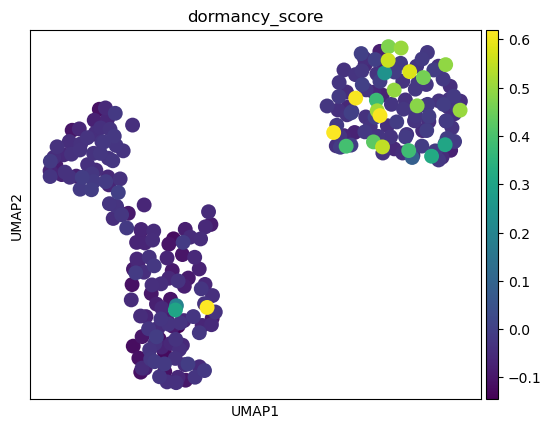

In [67]:
sc.pl.umap(ctc, color='dormancy_score')

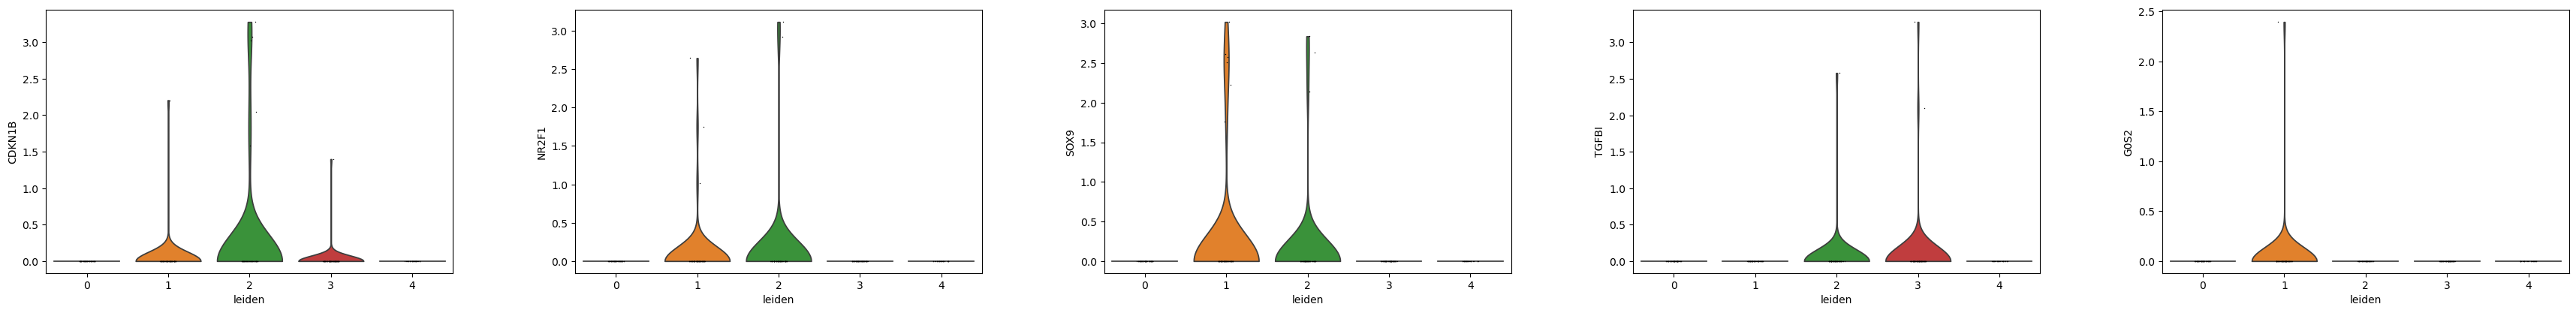

In [68]:
sc.pl.violin(ctc, keys=dormancy_markers, groupby='leiden')

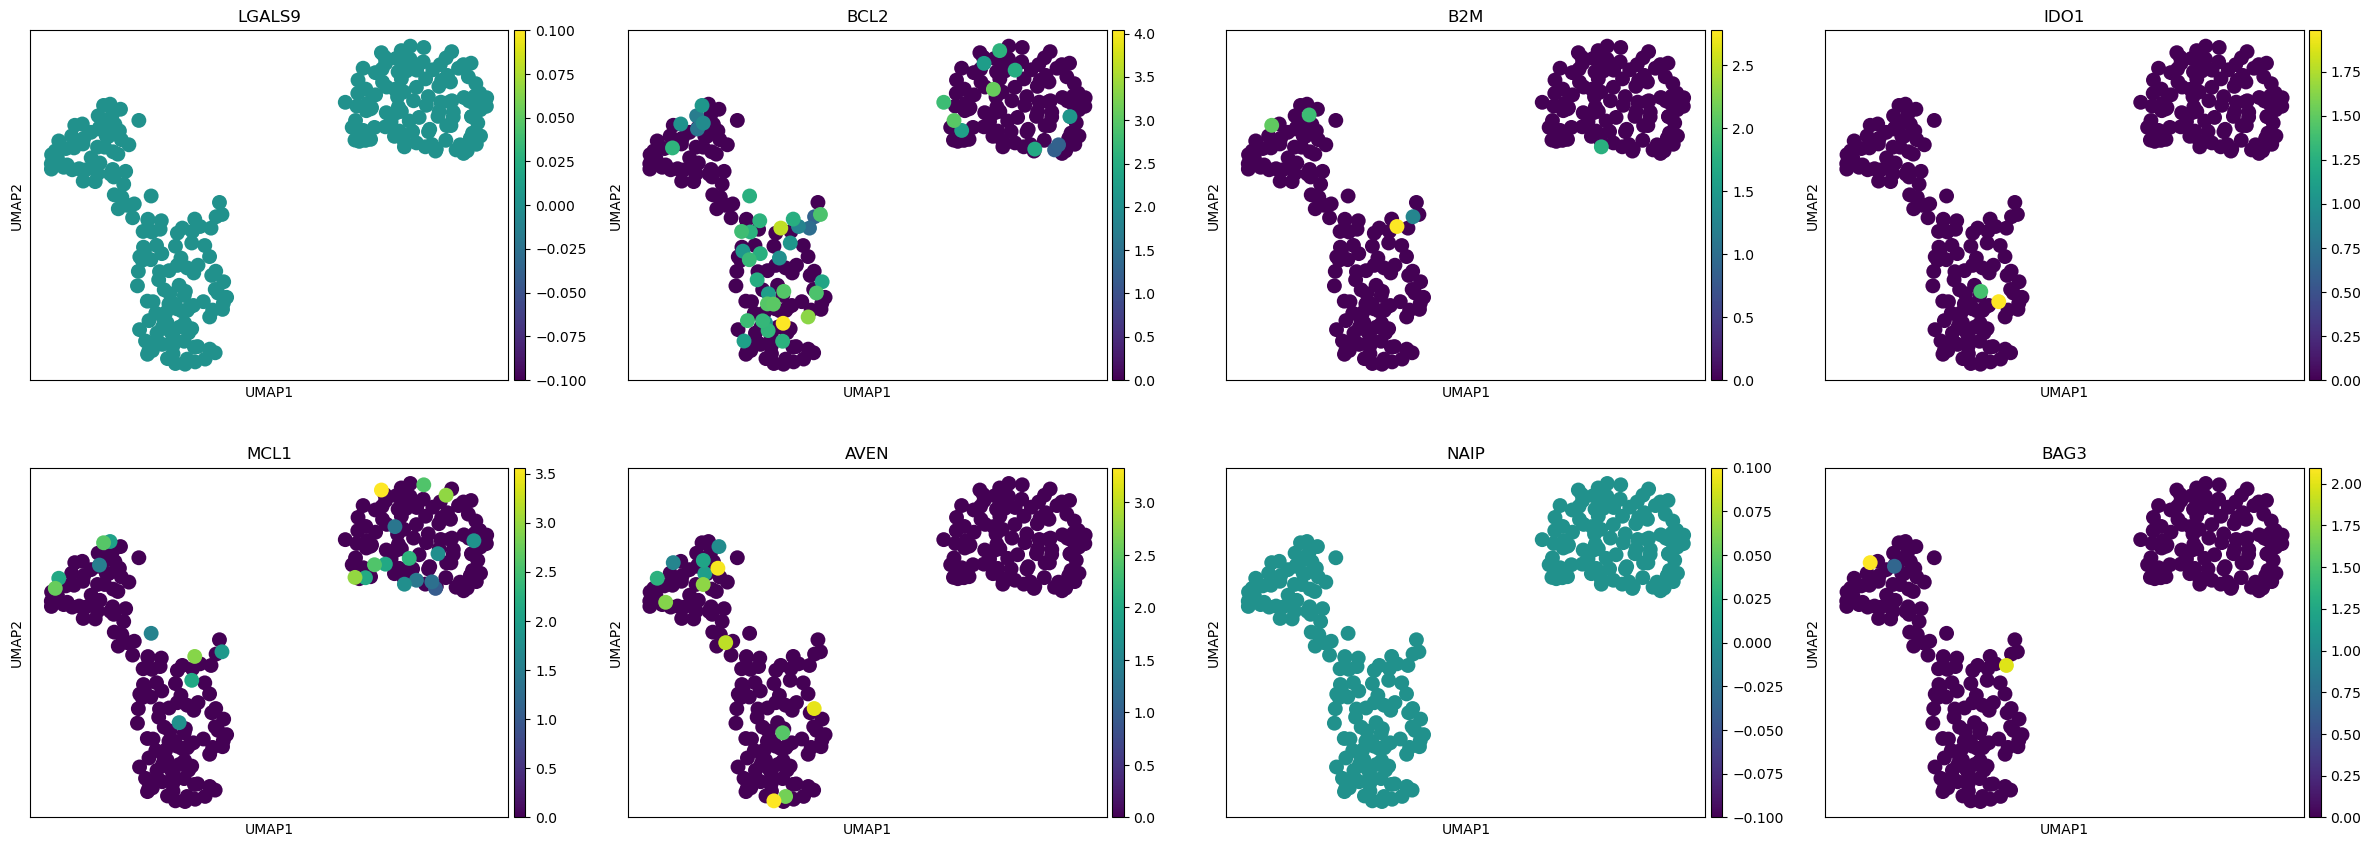

In [78]:
sc.pl.umap(ctc, color=['LGALS9', 'BCL2', 'B2M', 'IDO1', 'MCL1', 'AVEN', 'NAIP', 'BAG3'])

In [24]:
result = ctc.uns['rank_genes_groups']

# 获取群体名称
groups = result['names'].dtype.names

df = pd.DataFrame()

# 提取每个群体的前200个差异基因
for group in groups:
    genes = result['names'][group][:200]  # 提取前200个基因
    df[group] = genes

In [17]:
ctc.write_h5ad('ctc_heterogeneity.h5ad')

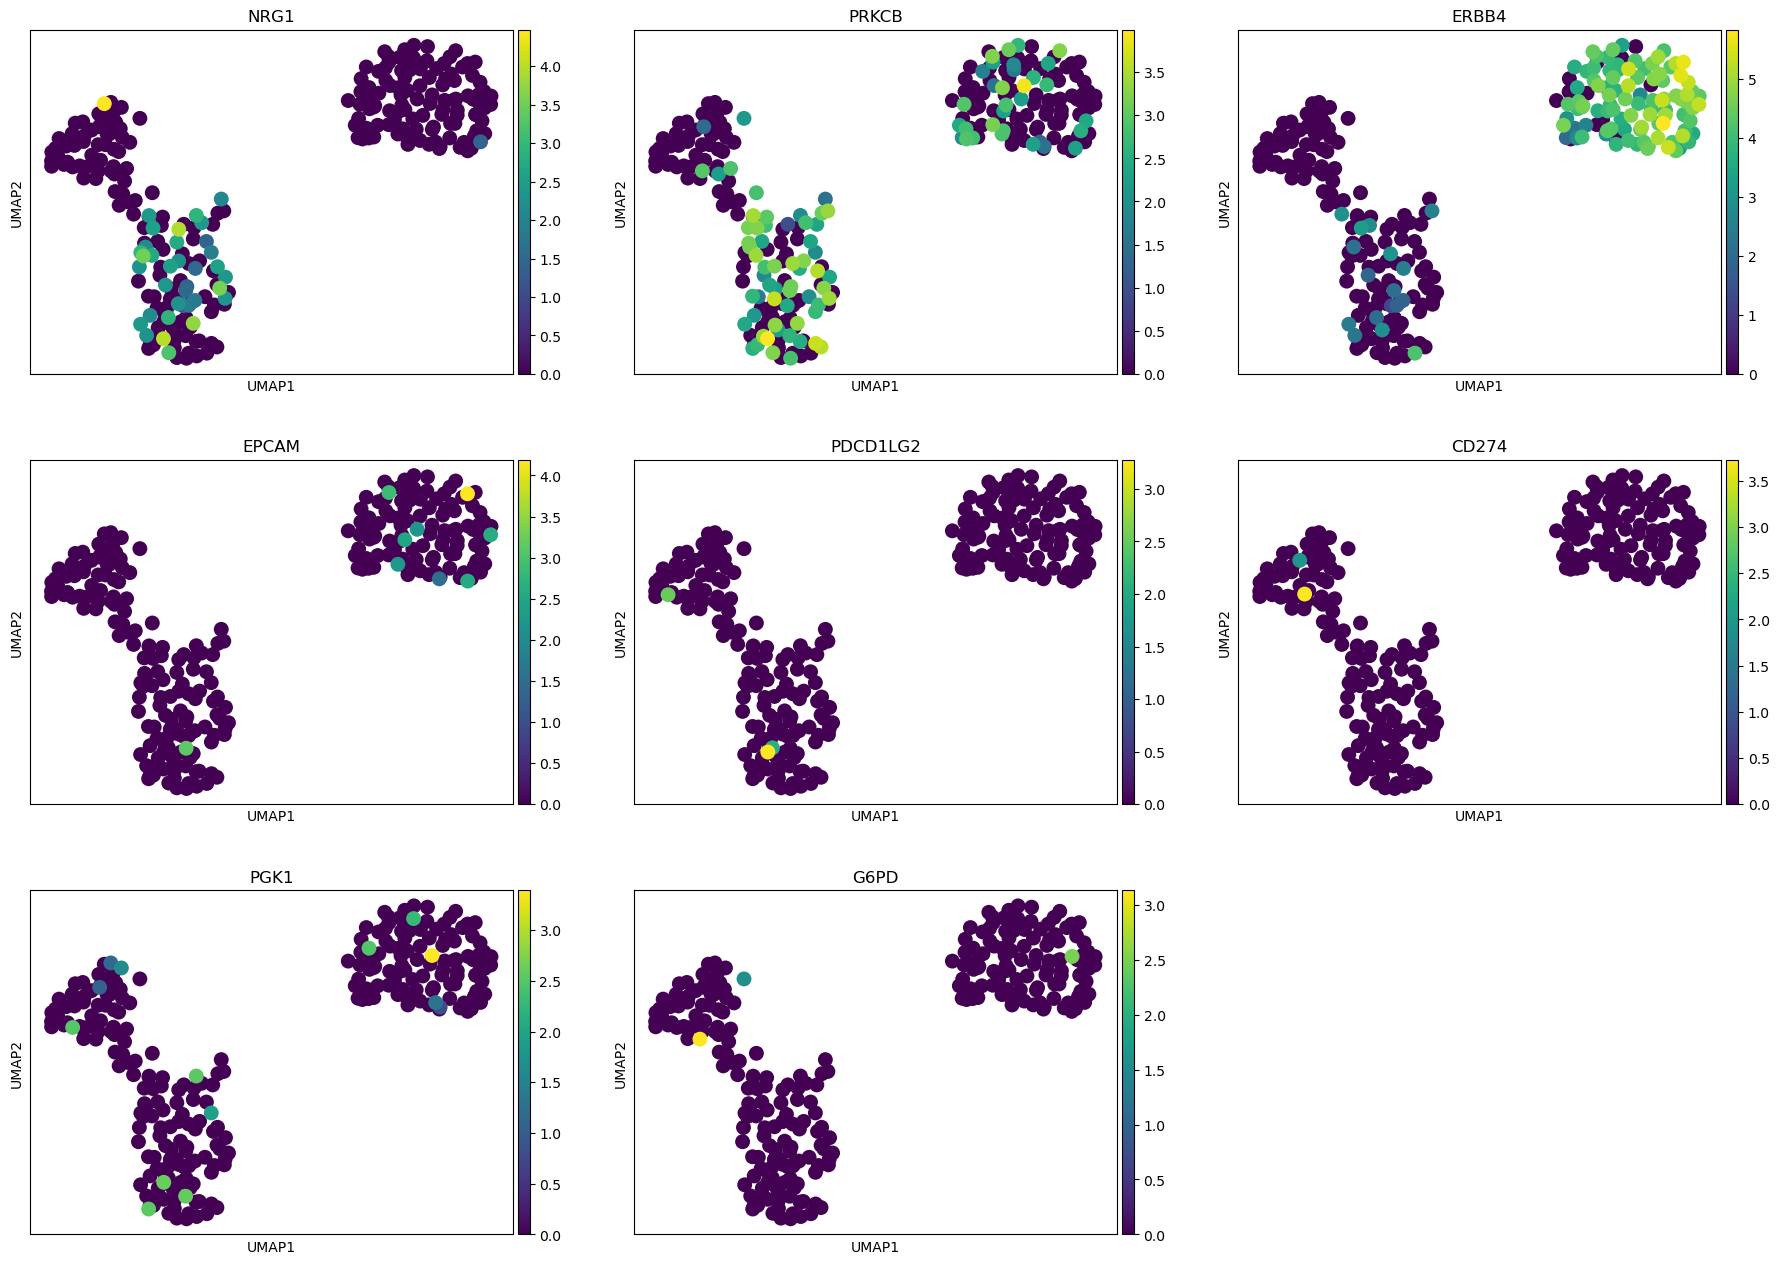

In [30]:
sc.pl.umap(ctc, color=['NRG1', 'PRKCB', 'ERBB4', 'EPCAM', 'PDCD1LG2', 'CD274', 'PGK1', 'G6PD'], vmin='0', ncols=3)

In [ ]:
sc.pl.umap(ctc, color=['CD274', 'CD44', 'ALDH1A1', 'SOX2', 'NANOG', "POU5F1"], vmin='0', ncols=2)